In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from model.nn_model import VAEClassifier, StAEClassifier
from pgd_purify import vae_purify, stae_purify, pgd_linf

In [2]:
batch_size=1024
num_visualize = 12
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
vae_classifier = VAEClassifier()
stae_classifier = StAEClassifier()
vae_classifier.load_state_dict(torch.load('./model/vae_clf.pth'))
stae_classifier.load_state_dict(torch.load('./model/stae_clf.pth'))
vae_classifier = vae_classifier.to(device)
stae_classifier = stae_classifier.to(device)
vae_classifier = vae_classifier.eval()
stae_classifier = stae_classifier.eval()

In [4]:
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
    ])), batch_size=batch_size, shuffle=False, num_workers=4)

In [5]:
def pred2label(y_pred_vae, y_pred_stae, labels):
    label_name = np.array(['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ank boot'])
    gt = labels.detach().cpu().numpy()
    pred_vae = y_pred_vae.argmax(-1).cpu().detach().numpy()
    pred_stae = y_pred_stae.argmax(-1).cpu().detach().numpy()
    label_selected = label_name[gt]
    vae_pred = label_name[pred_vae]
    stae_pred = label_name[pred_stae]
    print('Accuracy of the selected batch')
    acc_vae = np.sum(np.array(gt) == np.array(pred_vae)) / len(gt)
    acc_stae = np.sum(np.array(gt) == np.array(pred_stae)) / len(gt)
    print('Accuracy of Standard-AE-Classifier:', acc_stae)
    print('Accuracy of VAE-Classifier:', acc_vae)
    return label_selected, vae_pred, stae_pred


def top_k_vis(num_visualize, images, x_reconst_vae, x_reconst_stae):
    input_img = images[:num_visualize,0].detach().cpu().numpy()
    vae_reconst = x_reconst_vae[:num_visualize,0].detach().cpu().numpy()
    stae_reconst = x_reconst_stae[:num_visualize,0].detach().cpu().numpy()
    input_sample = np.concatenate(input_img, axis=1)
    reconst_vae = np.concatenate(vae_reconst, axis=1)
    reconst_stae = np.concatenate(stae_reconst, axis=1)
    return input_sample, reconst_vae, reconst_stae

# Selected 1st batch for visualization

In [6]:
gt_label = []
stae_pred = []
vae_pred = []
for batch_idx, (data, target) in enumerate(test_loader):
    images, labels = data.to(device), target.to(device)
    with torch.no_grad():
        x_reconst_vae, z, y_pred_vae, mu, log_var = vae_classifier(images, deterministic=True, classification_only=False)
        x_reconst_stae, z, y_pred_stae = stae_classifier(images, classification_only=False)
    
    break
    

label_selected, vae_pred, stae_pred = pred2label(y_pred_vae, y_pred_stae, labels)
input_sample, reconst_vae, reconst_stae = top_k_vis(num_visualize, images, x_reconst_vae, x_reconst_stae)


Accuracy of the selected batch
Accuracy of Standard-AE-Classifier: 0.9248046875
Accuracy of VAE-Classifier: 0.927734375


Visualization of first 12 samples


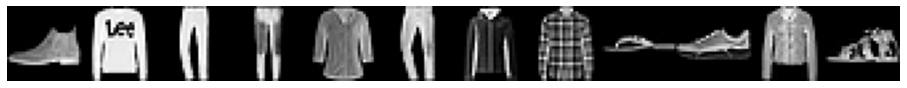

ground truth label:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal']


In [7]:
print('Visualization of first %d samples' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_sample, cmap='gray')
plt.axis('off') 
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))

Visualization of first 12 reconstructed samples for standard AE


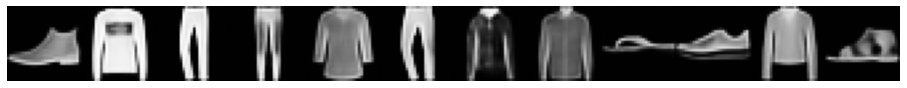

Standard-AE-Classifier prediction:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal']


In [8]:
print('Visualization of first %d reconstructed samples for standard AE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(reconst_stae, cmap='gray')
plt.axis('off') 
plt.show()

print('Standard-AE-Classifier prediction:')
print(list(stae_pred[:num_visualize]))

Visualization of first 12 reconstructed samples for VAE


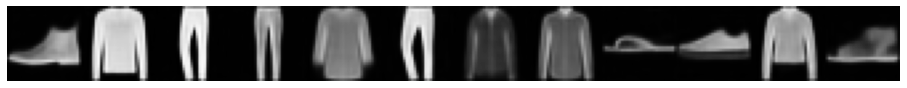

VAE-Classifier prediction:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal']


In [9]:
print('Visualization of first %d reconstructed samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(reconst_vae, cmap='gray')
plt.axis('off') 
plt.show()

print('VAE-Classifier prediction:')
print(list(vae_pred[:num_visualize]))

# Adversarial Examples

In [10]:
adv_vae = pgd_linf(images, labels, vae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)
adv_stae = pgd_linf(images, labels, stae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)

In [11]:
print('L_inf of adv perturbation:')
print('Standard-AE:', torch.max(torch.abs(images - adv_stae)).cpu().numpy())
print('VAE:', torch.max(torch.abs(images - adv_vae)).cpu().numpy())

L_inf of adv perturbation:
Standard-AE: 0.19607845
VAE: 0.19607845


In [12]:
with torch.no_grad():
    x_reconst_vae, z, y_pred_vae, mu, log_var = vae_classifier(adv_vae, deterministic=True, classification_only=False)
    x_reconst_stae, z, y_pred_stae = stae_classifier(adv_stae, classification_only=False)

label_selected, vae_pred, stae_pred = pred2label(y_pred_vae, y_pred_stae, labels)
input_adv_sample_vae, reconst_vae, _ = top_k_vis(num_visualize, adv_vae, x_reconst_vae, x_reconst_stae)
input_adv_sample_stae, _, reconst_stae = top_k_vis(num_visualize, adv_stae, x_reconst_vae, x_reconst_stae)

Accuracy of the selected batch
Accuracy of Standard-AE-Classifier: 0.0
Accuracy of VAE-Classifier: 0.0


Visualization of first 12 adversarial samples for ST-AE


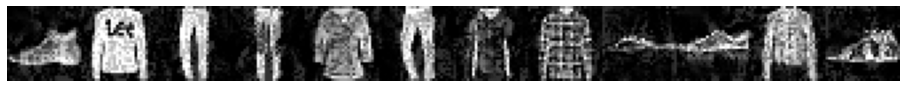

Reconstruction of Standard-AE-Classifier:


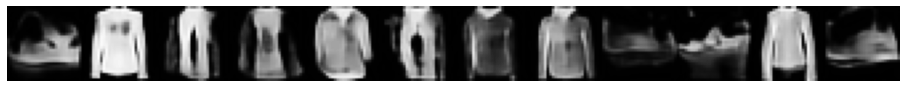

ground truth label:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal']
Standard-AE-Classifier prediction:
['sandal', 'shirt', 'shirt', 'dress', 'top', 'pullover', 'pullover', 'pullover', 'sneaker', 'sandal', 'shirt', 'sneaker']


In [13]:
print('Visualization of first %d adversarial samples for ST-AE' % (num_visualize))

plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_stae, cmap='gray')
plt.axis('off') 
plt.show()

print('Reconstruction of Standard-AE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_stae, cmap='gray')
plt.axis('off') 
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))

print('Standard-AE-Classifier prediction:')
print(list(stae_pred[:num_visualize]))

Visualization of first 12 adversarial samples for VAE


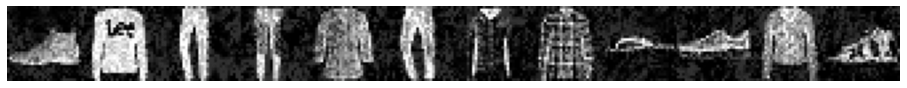

Reconstruction of VAE-Classifier:


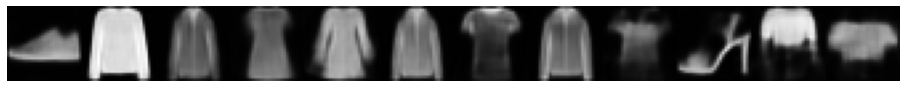

ground truth label:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal']
VAE-Classifier prediction:
['sneaker', 'shirt', 'coat', 'dress', 'dress', 'coat', 'top', 'coat', 'top', 'sandal', 'pullover', 'shirt']


In [14]:
print('Visualization of first %d adversarial samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_vae, cmap='gray')
plt.axis('off') 
plt.show()

print('Reconstruction of VAE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_vae, cmap='gray')
plt.axis('off') 
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))

print('VAE-Classifier prediction:')
print(list(vae_pred[:num_visualize]))

# Purified Examples

In [15]:
purify_data_vae = vae_purify(adv_vae, vae_classifier, atk_itr=96, eps=50/255, random_iteration=3, device=device)
purify_data_stae = stae_purify(adv_stae, stae_classifier, atk_itr=96, eps=50/255, random_iteration=3, device=device)

In [16]:
print('L_inf of purification:')
print('Standard-AE:', torch.max(torch.abs(purify_data_stae - adv_stae)).cpu().numpy())
print('VAE:', torch.max(torch.abs(purify_data_vae - adv_vae)).cpu().numpy())

L_inf of purification:
Standard-AE: 0.19607845
VAE: 0.19607845


In [17]:
with torch.no_grad():
    x_reconst_vae, z, y_pred_vae, mu, log_var = vae_classifier(purify_data_vae, deterministic=True, classification_only=False)
    x_reconst_stae, z, y_pred_stae = stae_classifier(purify_data_stae, classification_only=False)

label_selected, vae_pred, stae_pred = pred2label(y_pred_vae, y_pred_stae, labels)
input_pfy_sample_vae, reconst_vae, _ = top_k_vis(num_visualize, purify_data_vae, x_reconst_vae, x_reconst_stae)
input_pfy_sample_stae, _, reconst_stae = top_k_vis(num_visualize, purify_data_stae, x_reconst_vae, x_reconst_stae)

Accuracy of the selected batch
Accuracy of Standard-AE-Classifier: 0.1552734375
Accuracy of VAE-Classifier: 0.7109375


Visualization of first 12 adversarial samples for ST-AE


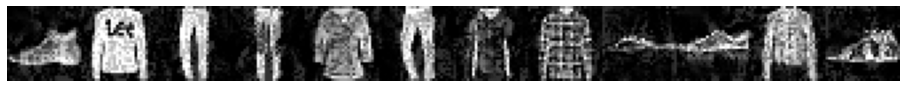

Visualization of first 12 purified samples for ST-AE


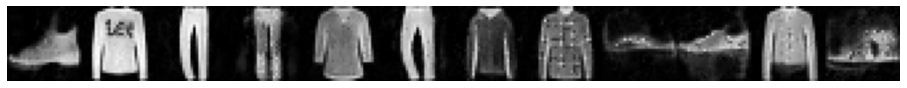

Reconstruction of Standard-AE-Classifier:


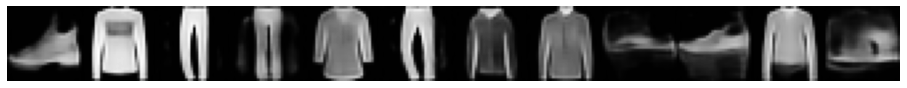

ground truth label:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal']
Standard-AE-Classifier prediction:
['sandal', 'shirt', 'shirt', 'dress', 'top', 'trouser', 'pullover', 'pullover', 'sneaker', 'sandal', 'shirt', 'sneaker']


In [18]:
print('Visualization of first %d adversarial samples for ST-AE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_stae, cmap='gray')
plt.axis('off') 
plt.show()

print('Visualization of first %d purified samples for ST-AE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_pfy_sample_stae, cmap='gray')
plt.axis('off') 
plt.show()

print('Reconstruction of Standard-AE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_stae, cmap='gray')
plt.axis('off') 
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))
print('Standard-AE-Classifier prediction:')
print(list(stae_pred[:num_visualize]))

Visualization of first 12 adversarial samples for VAE


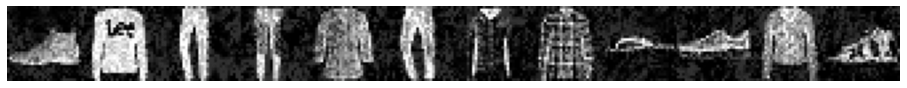

Visualization of first 12 purified samples for VAE


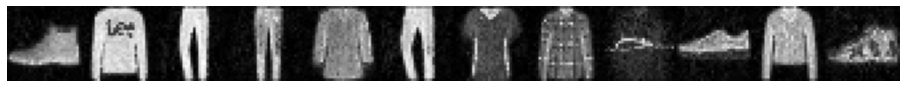

Reconstruction of VAE-Classifier:


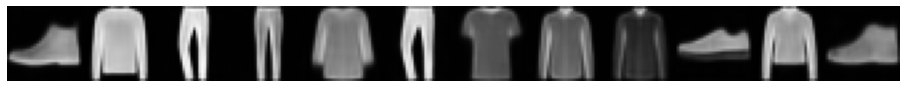

ground truth label:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal']
VAE-Classifier prediction:
['ank boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'top', 'shirt', 'shirt', 'sneaker', 'coat', 'sandal']


In [19]:
print('Visualization of first %d adversarial samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_vae, cmap='gray')
plt.axis('off') 
plt.show()

print('Visualization of first %d purified samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_pfy_sample_vae, cmap='gray')
plt.axis('off') 
plt.show()

print('Reconstruction of VAE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_vae, cmap='gray')
plt.axis('off') 
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))
print('VAE-Classifier prediction:')
print(list(vae_pred[:num_visualize]))